In [1]:
# d6598 
# "I bet computers can't make music"
# - Felonious Gru

# Note: Use "source activate tensorflow2_p36" on Ec2

beat_resolution = 12 # Standard of 24 for full 34 and 44 representation.
                    # Dont go below 8 otherwise risk distortion. 12 is a safe spot to end up
lookback = beat_resolution * 4 * 2  # Approx 2 bars
step = 1  # Skip through it a bit
num_pitches = 52  # Must be even cause odd numbers suck

%matplotlib inline
%load_ext tensorboard
import tensorflow as tf
import functions
import train
import generate
import datetime

Lower bound 38.
Upper bound 90.
Num pitches 52
---
midi/bwv653.mid input shape: (2746, 128)
...Refined down 76 dimensions with 81 note loss.
...Loss of 0.86 %
...Output shape: (2746, 52)
Extended output shape (2746, 52)


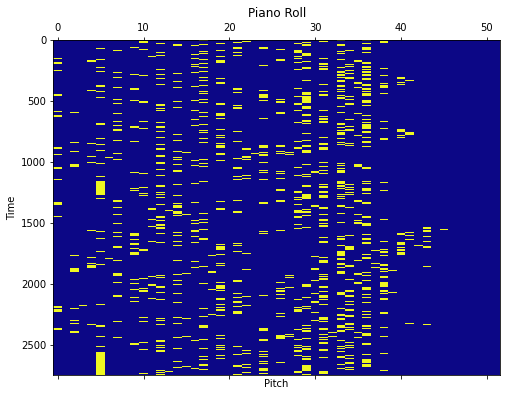

2650 individual phrases.


2021-07-07 10:01:15.494631: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                29952     
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dense_1 (Dense)              (None, 52)                6708      
Total params: 44,980
Trainable params: 44,980
Non-trainable params: 0
_________________________________________________________________
Model built.


In [2]:
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

music = functions.Midi(num_pitches, beat_resolution=beat_resolution)
music.load_midi(['midi/goldberg.mid'])
music.display()

x, y = music.vectorise(lookback, step=1)
tempo = music.tempo

gru = train.Gru("lstm-v14")
gru.build(lookback, num_pitches, loss="mse")

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=False, monitor="loss"),  # Stop early if training is only going ok
    train.GenerateMusic(music.roll, gen_every=3, temp=0.7),  # Generate some music
    tf.keras.callbacks.ModelCheckpoint(gru.model_dir + gru.name + ".h5",
                                       save_best_only=True, monitor="loss"),
    tf.keras.callbacks.ProgbarLogger(),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
]

In [3]:
historys = gru.train(x, y, 100, callbacks, batch_size=128)
train.plot_history(historys)
#gru.load("models/lstm-v13.h5")

Epoch 1/50


2021-07-07 10:01:15.750946: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


      0/Unknown - 4s 0s/sample - loss: 0.2459 - acc: 0.0219 - mean_absolute_error: 0.4953    

KeyError: 'acc'

In [ ]:
# Can also run without % in the command line
%tensorboard --logdir logs/

In [6]:
temps = [0.2, 0.35, 0.4, 0.45, 0.5, 0.6, 0.8, 1.0]

outputs = {}
for temp in temps:
    outputs["Temp-" + str(temp)] = generate.generate_music(gru.model, music.roll, temp, length=lookback*4, noise=True)
generate.multi_save(outputs, 'outputs/generated-v14.mid')

Generating with seed index of 2616
Generating roll with temp 0.35 and length 384
Generating with seed index of 2601
Generating roll with temp 0.4 and length 384
Generating with seed index of 1977
Generating roll with temp 0.45 and length 384
Roll is cut down to only 52 notes
Roll is cut down to only 52 notes
Roll is cut down to only 52 notes
Saving 3 tracks in one file "outputs/generated-v14.mid".
Saved file "outputs/generated-v14.mid".
